In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
model_order = ['gpt', 'palm', 'opus', 'nllb', 'google']
lang_order = ["en-de", "en-zh", "en-es", "en-ko", "en-hu", "en-hi", "en-he", "en-yo", "Average"]

def averageit(df):
    for model in model_order:
        score = df[df['model'] == model]['score'].mean()
        df = df.append({'model': model, 'language_pair': 'Average', 'score': score}, ignore_index=True)
    return df

def sortit(df):
    df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)
    df = df.sort_values(by='model', kind='stable').reset_index(drop=True)
    df['language_pair'] = pd.Categorical(df['language_pair'], categories=lang_order, ordered=True)
    df = df.sort_values(by='language_pair', kind='stable').reset_index(drop=True)

    return df

def dropit(df):
    df = df.drop(df[(df['model'] == 'opus') & (df['language_pair'] == 'en-ko')].index)
    return df

def renameit(df):
    def f(x):
        if x == 'gpt': return "ChatGPT"
        if x == 'palm': return "PaLM 2"
        if x == 'opus': return 'Opus MT'
        if x == 'nllb': return 'NLLB'
        if x == 'google': return "Google Translate"
        return None
    df['model'] = df['model'].apply(f)
    return df

def preprocess(df):
    return renameit(sortit(averageit(df)))


import warnings
warnings.filterwarnings("ignore")

# Now sort the DataFrame according to this order
usw = preprocess(pd.read_csv("usw_a.csv"))
nm = preprocess(pd.read_csv("nm_a.csv"))
sensitivity_diff_chrp = preprocess(pd.read_csv("sensitivity_diff_chrp.csv"))
sensitivity_diff_bert = preprocess(pd.read_csv("sensitivity_diff_bert.csv"))
sensitivity_min_chrp = preprocess(pd.read_csv("sensitivity_min_chrp.csv"))
sensitivity_min_bert = preprocess(pd.read_csv("sensitivity_min_bert.csv"))
sensitivity_aligncomet = preprocess(pd.read_csv("sensitivity_aligncomet.csv"))

import matplotlib as mpl
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{lmodern}"  # Replace with your desired font package

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def normalize_scores(data, average):
    # Concatenate data and average to create a unified dataframe
    combined_data = pd.concat([data, average])

    # Filter out rows with score of zero
    combined_data_non_zero = combined_data[combined_data['score'] != 0]

    # Calculate average score for each language_pair ignoring zero values
    avg_scores = combined_data_non_zero.groupby('language_pair')['score'].mean().reset_index()

    # Merge average score with unified dataframe for normalization
    combined_data = combined_data.merge(avg_scores, on='language_pair', how='left', suffixes=('', '_avg'))

    # Normalize the scores
    combined_data['score'] = combined_data['score'].divide(combined_data['score_avg'], fill_value=1)

    # Drop the average score columns
    combined_data.drop('score_avg', axis=1, inplace=True)

    # Separate combined_data back into data and average
    data = combined_data[combined_data['language_pair'] != 'Average']
    average = combined_data[combined_data['language_pair'] == 'Average']

    return data, average



def plot_translation_score(data, ylabel, file):

    params = {
        'xtick.labelsize': 22
    }
    plt.rcParams.update(params)

    data, average = data[data['language_pair'] != 'Average'], data[data['language_pair'] == 'Average'].reset_index(drop=True)
    data, average = normalize_scores(data, average)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, width_ratios=[7, 1], figsize=(16, 6))
    
    plt.subplots_adjust(wspace=0)
    f.tight_layout() 
    sns.set_theme(style="whitegrid", font_scale=1.6,)

    # Palette for the models
    palette = {
        "ChatGPT": "#5499C7",
        "PaLM 2": "#5499C7",
        "Opus MT": "#FF8633",
        "NLLB": "#FF8633",
        "Google Translate": "#AAB7B8",
    }
    model_order = ['ChatGPT', 'PaLM 2', 'Opus MT', 'NLLB', 'Google Translate']
    lang_order = ["en-de", "en-zh", "en-es", "en-ko", "en-hu", "en-hi", "en-he", "en-yo"]
    min_score = min(data[data['score'] != 0]['score'])
    norm_factor = 1.8
    
    # Create the plot
    sns.barplot(x="language_pair", y="score", hue="model", data=data, palette=palette, 
                order=lang_order, hue_order=model_order, ax=ax1, width=0.8)
    sns.barplot(x="language_pair", y="score", hue="model", data=average, palette=palette, order=["Average"],
                alpha=1, ax=ax2, width=0.7)
    ax2.get_xticklabels()[-1].set_fontweight("bold")
   


    for bar in ax1.patches:
        x_val = bar.get_x() + bar.get_width() / 2  # get the x-value of the center of the bar
        y_val = bar.get_height()  # get the height of the bar
        if (y_val == data.loc[(data["model"] == "Opus MT") & (data["language_pair"] == "en-ko"), "score"].values[0]) \
                and (x_val > lang_order.index("en-ko") - 0.5 and x_val < lang_order.index("en-ko") + 0.5):
            ax1.text(x_val, y_val + min_score/norm_factor, 'x', ha="center", va="bottom", color="#AAB7B8", fontweight='bold')

    
    hatches = ["\\", ".", "x", "-", ""]

    # Customizing the axes and legend
    ax1.set_ylabel(ylabel, fontsize=28)
    ax2.set_ylabel("")
    
    for ax in [ax1, ax2]:
        ax.set_xlabel("")
        for bars, hatch in zip(ax.containers, hatches):
            for bar in bars:
                bar.set_hatch(hatch)
        for d in {'top', 'right', 'left'}:
            ax.spines[d].set_visible(False)

    for lp, hatch in zip(ax1.legend().get_patches(), hatches):
        lp.set_hatch(hatch)
        
    ax1.set_ylim(bottom=min_score/norm_factor)
    handles, labels = ax1.get_legend_handles_labels()
    for ax in [ax1, ax2]:
        ax.get_legend().remove()

    # Get the bounds of the subplots: [x0, y0, width, height]
    bounds1 = ax1.get_position().bounds
    bounds2 = ax2.get_position().bounds
    line_x = bounds1[0] + bounds1[2] + (bounds2[0] - (bounds1[0] + bounds1[2])) / 2
    # Add the line to the figure
    line = Line2D([line_x, line_x], [0.1, 0.9], transform=f.transFigure, color='#AAB7B8', linestyle='--')
    f.lines.append(line)
    f.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.06), frameon=False, fontsize=20)
    plt.savefig(file, bbox_inches="tight")


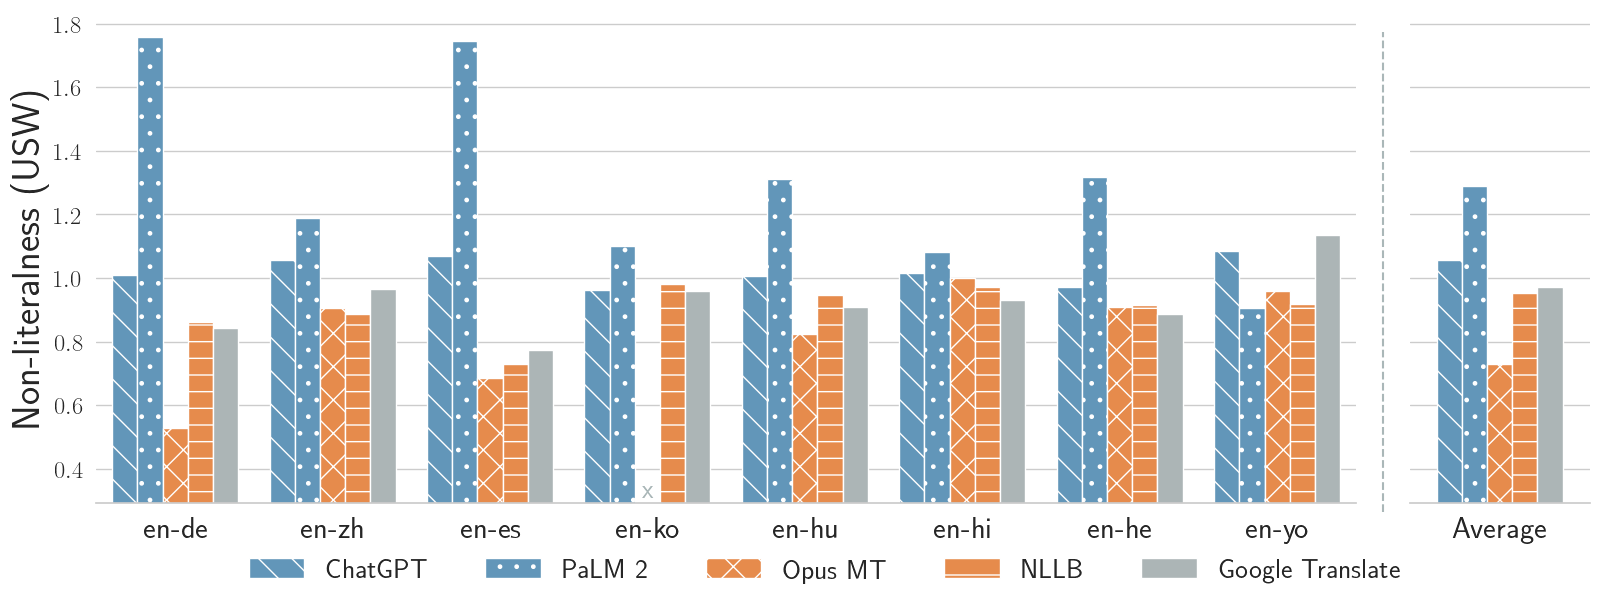

In [148]:
plot_translation_score(usw, "Non-literalness (USW)", "./figures/usw.png")

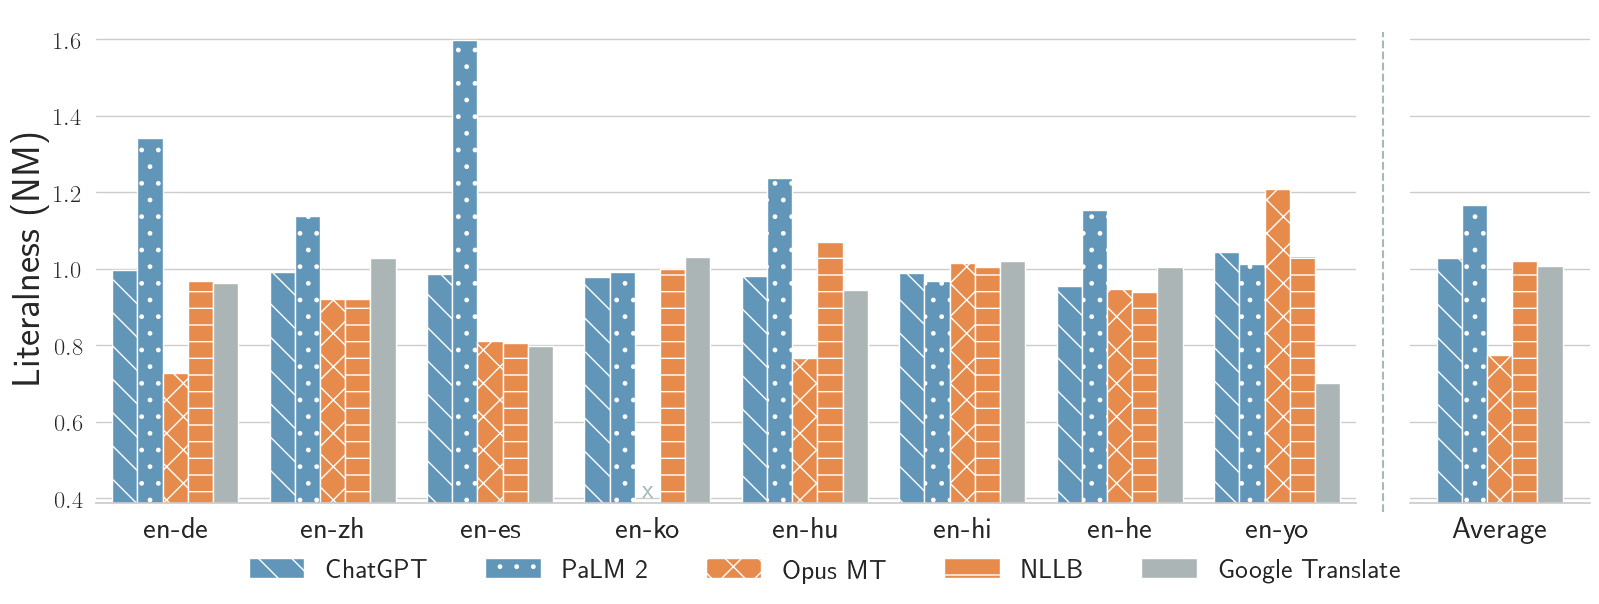

In [151]:
plot_translation_score(nm, "Literalness (NM)", "./figures/nm.png")

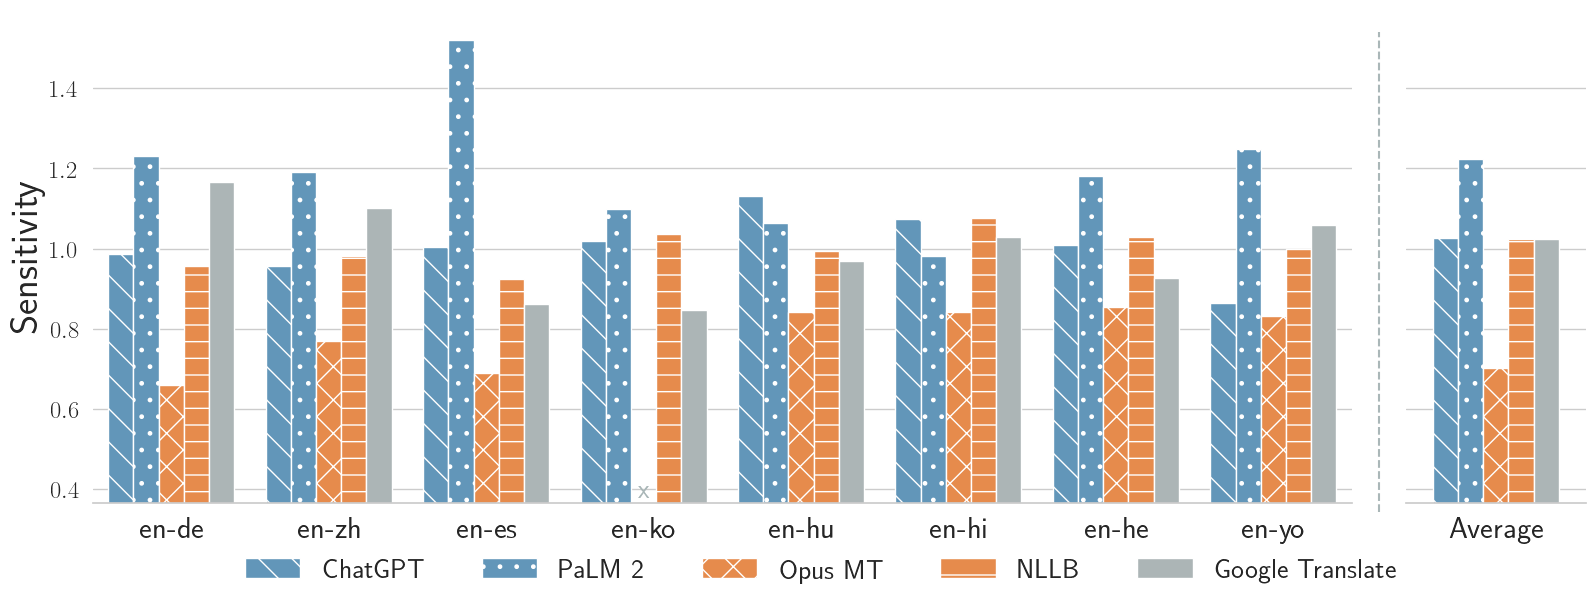

In [152]:
plot_translation_score(sensitivity_diff_bert
        , "Sensitivity", "./figures/sensitivity_diff_bert.png")

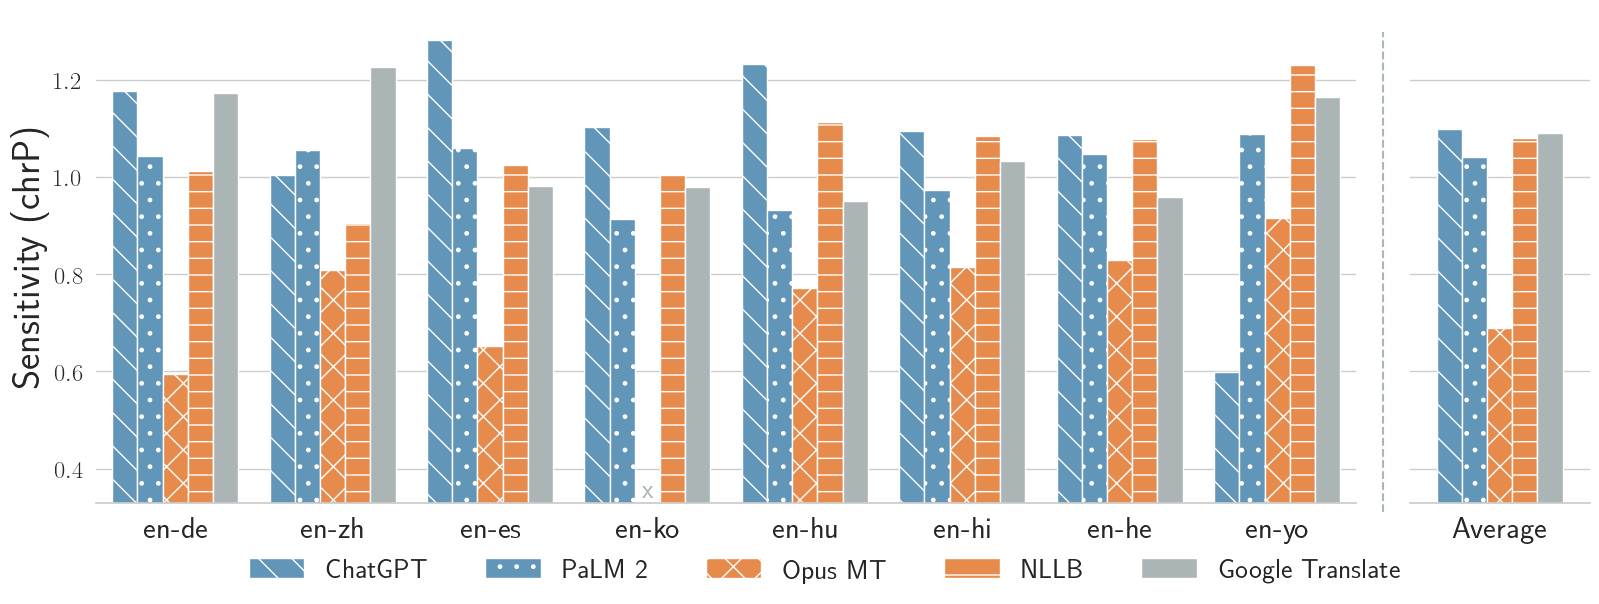

In [153]:
plot_translation_score(sensitivity_diff_chrp
        , "Sensitivity (chrP)", "./figures/sensitivity_diff_chrp.png")

In [154]:
def normalize_scores(df):
    # Concatenate data1 and data2
    combined_data = pd.concat([df[0], df[1]])

    # Filter out rows with score of zero
    combined_data_non_zero = combined_data[combined_data['score'] != 0]

    # Calculate average score for each language_pair ignoring zero values
    avg_scores = combined_data_non_zero.groupby('language_pair')['score'].mean().reset_index()

    # Merge average score with original dataframes for normalization
    for i, data in enumerate(df):
        df[i] = data.merge(avg_scores, on='language_pair', how='left', suffixes=('', '_avg'))
        # Avoid dividing by NaN for rows that were originally zero and got excluded in the average calculation
        df[i]['score'] = df[i]['score'].divide(df[i]['score_avg'], fill_value=1)
        df[i].drop('score_avg', axis=1, inplace=True)
    return df


def plot_translation_score(data1, data2, file):

    params = {
        'xtick.labelsize': 22
    }
    plt.rcParams.update(params)

    lang_order = ['en-zh', 'en-ko', 'en-he', 'en-yo']
    data1 = renameit(data1[data1['language_pair'].isin(lang_order)])
    data2 = renameit(data2[data2['language_pair'].isin(lang_order)])
    data1, data2 = normalize_scores([data1, data2])

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
    
    plt.subplots_adjust(wspace=0)
    f.tight_layout() 
    sns.set_theme(style="whitegrid", font_scale=1.6,)

    # Palette for the models
    palette = {
        "ChatGPT": "#5499C7",
        "PaLM 2": "#5499C7",
        "Opus MT": "#FF8633",
        "NLLB": "#FF8633",
        "Google Translate": "#AAB7B8",
    }
    model_order = ['ChatGPT', 'PaLM 2', 'Opus MT', 'NLLB', 'Google Translate']
    min_score = min(min(data1[data1['score'] != 0]['score']), min(data2[data2['score'] != 0]['score']))
    norm_factor = 1.2
    
    for ax, data in [(ax1, data1), (ax2, data2)]:

        sns.barplot(x="language_pair", y="score", hue="model", data=data, palette=palette, 
                order=lang_order, hue_order=model_order, ax=ax, width=0.8)
        for bar in ax.patches:
            x_val = bar.get_x() + bar.get_width() / 2  # get the x-value of the center of the bar
            y_val = bar.get_height()  # get the height of the bar
            if (y_val == data.loc[(data["model"] == "Opus MT") & (data["language_pair"] == "en-ko"), "score"].values[0]) \
                    and (x_val > lang_order.index("en-ko") - 0.5 and x_val < lang_order.index("en-ko") + 0.5):
                ax.text(x_val, y_val + min_score/norm_factor, 'x', ha="center", va="bottom", color="#AAB7B8", fontweight='bold')

    hatches = ["\\", ".", "x", "-", ""]
    ax1.set_ylabel("Correctness", fontsize=28)
    ax2.set_ylabel("")
    ax1.set_title("Literal Translation", fontsize=26)
    ax2.set_title("Figurative Translation", fontsize=26)
    
    for ax in [ax1, ax2]:
        ax.set_xlabel("")
        for bars, hatch in zip(ax.containers, hatches):
            for bar in bars:
                bar.set_hatch(hatch)
        for d in {'top', 'right', 'left'}:
            ax.spines[d].set_visible(False)

    for lp, hatch in zip(ax1.legend().get_patches(), hatches):
        lp.set_hatch(hatch)
        
    ax1.set_ylim(bottom=min_score/norm_factor)
    handles, labels = ax1.get_legend_handles_labels()
    for ax in [ax1, ax2]:
        ax.get_legend().remove()

    # Get the bounds of the subplots: [x0, y0, width, height]
    bounds1 = ax1.get_position().bounds
    bounds2 = ax2.get_position().bounds
    line_x = bounds1[0] + bounds1[2] + (bounds2[0] - (bounds1[0] + bounds1[2])) / 2
    # Add the line to the figure
    line = Line2D([line_x, line_x], [0.1, 0.9], transform=f.transFigure, color='#AAB7B8', linestyle='--')
    f.lines.append(line)
    f.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.06), frameon=False, fontsize=20)
    plt.savefig(file, bbox_inches="tight")



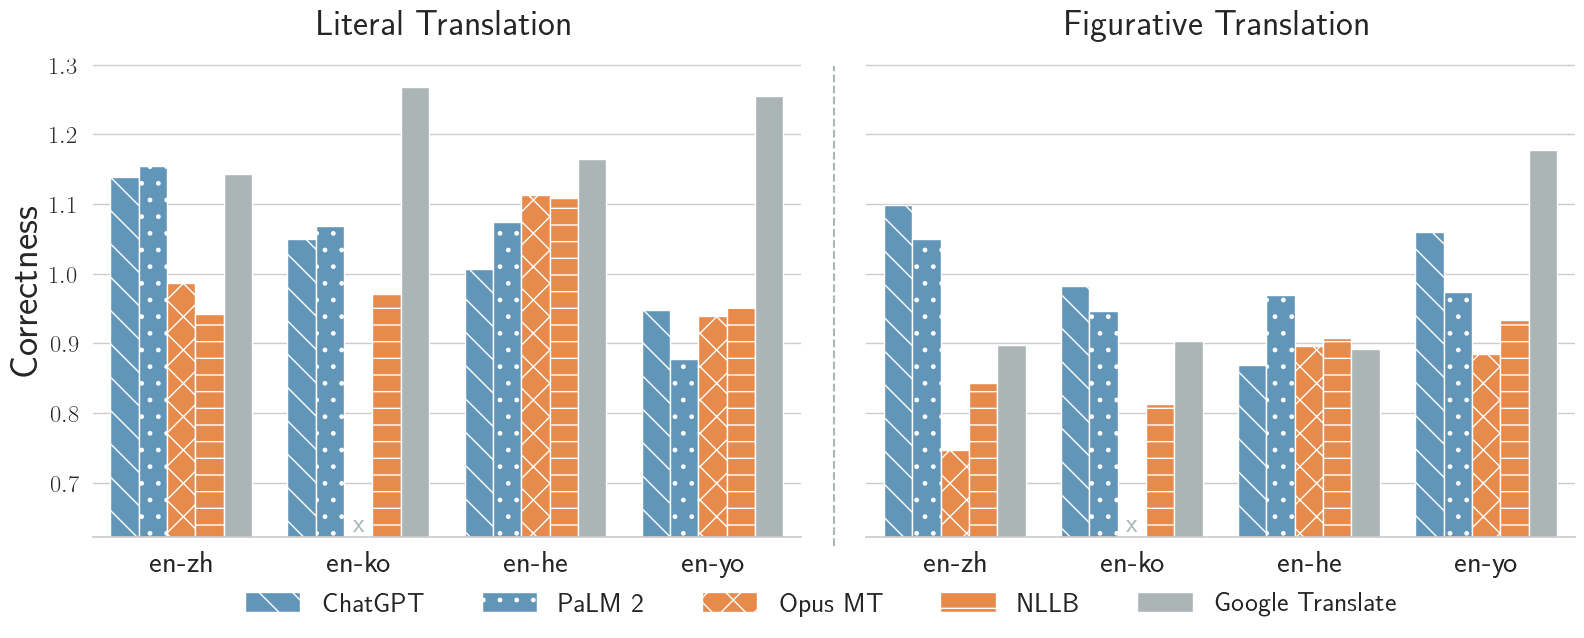

In [155]:
bi_lit = sortit(pd.read_csv("default/bi_lit_bleurt.csv"))
bi_fig = sortit(pd.read_csv("default/bi_fig_bleurt.csv"))

# Call the function
plot_translation_score(pd.DataFrame(bi_lit), pd.DataFrame(bi_fig), 
                         "./figures/bi_bleurt.png")